In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import Input, Sequential
from tensorflow.python.keras.engine.functional import Functional
from tensorflow.python.keras.models import Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from tensorflow.keras.layers import (Dense, Lambda, Conv2D, Conv2DTranspose, LeakyReLU, 
                                    BatchNormalization,ZeroPadding2D, Activation ,Flatten, Reshape, Cropping2D, Dropout)
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K

import glob
import imageio
import os
import PIL
import time

from IPython import display
from tensorflow.keras.optimizers import Adam, RMSprop

import tensorflow_docs.vis.embed as embed

1 Physical GPUs, 1 Logical GPUs


## Import the MNIST data class and call it.

In [2]:
import MNIST_dataset as mnist
data = mnist.MNISTData(gan=True)

## Deep Convolutional Generative Adversarial Network with TensorFlow

The aim of this exercise is to implement a DCGAN architecture and to test it on the MNIST dataset.

Code partially adapted from [TensorFlow Documentation](https://www.tensorflow.org/tutorials/generative/dcgan).

In [3]:
class DCGAN():
    """Deep Convolutional Generative Adversarial Network"""
    
    batch_size = 256

    def __init__(self, data: mnist.MNISTData):

        self.x_train = data.x_train
        self.buffer_size = self.x_train.shape[0]

        #Preparing dataset for the custom training
        self.train_dataset = tf.data.Dataset.from_tensor_slices(self.x_train)
        self.train_dataset = self.train_dataset.shuffle(self.buffer_size).batch(self.batch_size)
        
        self.latent_dim = 100

        self.generator = None
        self.g_optimizer = None        
        self.discriminator = None
        self.d_optimizer = None

        # Instantiate a loss function, i.e. function to compute the cross entropy loss
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        #store geneterator and discriminator loss
        self.loss_record = np.array([None, None])
        
    def make_generator_model(self, optimizer = Adam(learning_rate=1e-4)):
        """Building the generator model."""

        self.g_optimizer = optimizer
        self.generator = Sequential(
            [
                Input(shape=(self.latent_dim,)),
                # Starting with 100 dimension and then we scale it up to reach the proper shape
                # We want to generate 100 coefficients to reshape into a 7x7x256 map
                # Remember: only the stides should affect my output size   
                Dense(7 * 7 * 256, use_bias=False),
                BatchNormalization(momentum=0.8),
                LeakyReLU(alpha=0.2),
                Reshape((7, 7, 256)),

                #inverse of convolutional layer
                Conv2DTranspose(128, kernel_size=5, padding='same', use_bias=False),
                BatchNormalization(momentum=0.8),
                LeakyReLU(alpha=0.2),
        
                Conv2DTranspose(64, kernel_size=5, strides=(2, 2), padding='same', use_bias=False),
                BatchNormalization(momentum=0.8),
                LeakyReLU(alpha=0.2),

                Conv2DTranspose(1, kernel_size=5, strides=(2, 2), padding='same', use_bias=False),
                Activation("tanh"),
            ],
            name="generator",
        )
        #assert self.generator.output_shape == (None, 28, 28, 1)

    def make_discriminator_model(self, optimizer = Adam(learning_rate=5e-5)):
        """Building the discriminator model which is an image recognition model."""

        self.d_optimizer = optimizer
        self.discriminator = Sequential(
            [
                Input(shape=(28, 28, 1)),
                Conv2D(64, kernel_size=5, strides=(2, 2), padding='same'),
                LeakyReLU(alpha=0.2),
                Dropout(0.25),

                Conv2D(128, kernel_size=5, strides=(2, 2), padding='same'),
                LeakyReLU(alpha=0.2),
                Dropout(0.25),

                # Flatten all together and map into a single dense layer which gives us True or False
                Flatten(),
                Dense(1),
                Activation('sigmoid'),
            ],
            name="discriminator"
        )
                   
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def generator_loss(self, fake_output):
        return self.loss_fn(tf.ones_like(fake_output), fake_output)

    def train_dcgan(self, epochs=500, save_interval = 10):
        """Training loop."""
        seed = tf.random.normal([16, self.latent_dim])
        start_loop = time.time()
        for epoch in range(epochs):
            start_epoch = time.time()

            for image_batch in self.train_dataset:
                gen_loss, disc_loss = self.train_step(tf.cast(image_batch,float))

            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start_epoch))
            print('Generation loss: {} Discriminator loss: {} '.format(gen_loss, disc_loss))
            self.loss_record = np.vstack([self.loss_record, np.array([gen_loss, disc_loss])])
        
            # If at save interval, than save and disply the generated image samples
            if epoch % save_interval == 0:
                self.generate_and_save_images(epoch + 1, seed)

        print("\nTotal time taken: %.2fs" % (time.time() - start_loop))
        print("\n\n\n")

    # The function to be "compiled".
    @tf.function
    def train_step(self, images):
        """GAN training step."""
        
        # Sample normally distributed points in the latent space
        random_latent_vec = tf.random.normal([self.batch_size, self.latent_dim])
    
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            gen_imgs = self.generator(random_latent_vec, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(gen_imgs, training=True)

            g_loss = self.generator_loss(fake_output)
            d_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = g_tape.gradient(g_loss, self.generator.trainable_variables)
        gradients_of_discriminator = d_tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        return g_loss, d_loss
    
    def generate_and_save_images(self, epoch, test_input, save=True):

        pred = self.generator(test_input, training=False)

        fig = plt.figure(figsize=(4, 4))

        for i in range(pred.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(pred[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        if save:
            plt.savefig('./images/GAN/training_checkpoints/image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

    def gif(self):
        """Creation of the gif with generated images over epochs."""

        with imageio.get_writer('./images/GAN/dcgan.gif', mode='I') as writer:
            filenames = glob.glob('./images/GAN/training_checkpoints/image*.png')
            filenames = sorted(filenames)
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)
            image = imageio.imread(filename)
            writer.append_data(image)
            embed.embed_file('./images/GAN/dcgan.gif')
    
    def plot_losses(self):
        """Plotting the Generator and Discriminator losses"""
        plt.plot(self.loss_record[:])
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Generator Loss', 'Discriminator Loss'], loc='best')
        plt.title('Generator and Discriminator losses')
        plt.savefig('./images/GAN/g_d_losses.png')

        plt.show()
    
    def dir(self):
        """Creation of the folders path to store the results."""
        dir = os.path.join("images")
        if not os.path.exists(dir):
            os.mkdir(dir)
        dir2 = os.path.join("./images/GAN")
        if not os.path.exists(dir2):
            os.mkdir(dir2)
        dir3 = os.path.join("./images/GAN/training_checkpoints")
        if not os.path.exists(dir3):
            os.mkdir(dir3)



/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


Time for epoch 1 is 26.450862169265747 sec
Generation loss: 0.6366156935691833 Discriminator loss: 1.1922187805175781 


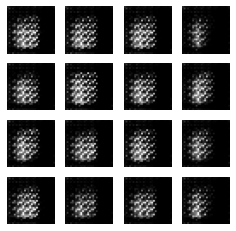

Time for epoch 2 is 24.409884452819824 sec
Generation loss: 0.6576040983200073 Discriminator loss: 1.3898584842681885 
Time for epoch 3 is 24.470492124557495 sec
Generation loss: 0.6284387111663818 Discriminator loss: 1.4050722122192383 
Time for epoch 4 is 24.50720453262329 sec
Generation loss: 0.6730262041091919 Discriminator loss: 1.4278290271759033 
Time for epoch 5 is 24.463303089141846 sec
Generation loss: 0.714038074016571 Discriminator loss: 1.2998613119125366 
Time for epoch 6 is 24.572487831115723 sec
Generation loss: 0.7276344299316406 Discriminator loss: 1.3961673974990845 
Time for epoch 7 is 24.55902647972107 sec
Generation loss: 0.6860306859016418 Discriminator loss: 1.3639447689056396 
Time for epoch 8 is 24.567805528640747 sec
Generation loss: 0.6917208433151245 Discriminator loss: 1.4011050462722778 
Time for epoch 9 is 24.47160315513611 sec
Generation loss: 0.7330641746520996 Discriminator loss: 1.3493083715438843 
Time for epoch 10 is 24.528580904006958 sec
Generati

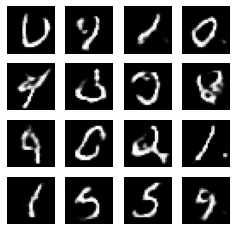

Time for epoch 52 is 24.486167192459106 sec
Generation loss: 0.7736532092094421 Discriminator loss: 1.2180368900299072 
Time for epoch 53 is 24.47185230255127 sec
Generation loss: 0.9121396541595459 Discriminator loss: 1.3220003843307495 
Time for epoch 54 is 24.55121159553528 sec
Generation loss: 0.8581744432449341 Discriminator loss: 1.2585810422897339 
Time for epoch 55 is 24.556457996368408 sec
Generation loss: 0.662219762802124 Discriminator loss: 1.4453840255737305 
Time for epoch 56 is 24.527060747146606 sec
Generation loss: 0.8173899054527283 Discriminator loss: 1.2765244245529175 
Time for epoch 57 is 24.5465989112854 sec
Generation loss: 0.7790800929069519 Discriminator loss: 1.3372139930725098 
Time for epoch 58 is 24.60479235649109 sec
Generation loss: 0.8257735371589661 Discriminator loss: 1.2952001094818115 
Time for epoch 59 is 24.547473192214966 sec
Generation loss: 0.8493360877037048 Discriminator loss: 1.1661858558654785 
Time for epoch 60 is 24.576788187026978 sec
Ge

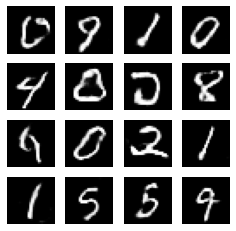

Time for epoch 102 is 24.502715349197388 sec
Generation loss: 0.8005692362785339 Discriminator loss: 1.182018756866455 
Time for epoch 103 is 24.485464334487915 sec
Generation loss: 0.8927517533302307 Discriminator loss: 1.2109969854354858 
Time for epoch 104 is 24.479087829589844 sec
Generation loss: 0.6974508762359619 Discriminator loss: 1.3409206867218018 
Time for epoch 105 is 24.57222604751587 sec
Generation loss: 0.8040576577186584 Discriminator loss: 1.2687710523605347 
Time for epoch 106 is 24.509342670440674 sec
Generation loss: 0.7856907844543457 Discriminator loss: 1.3286076784133911 
Time for epoch 107 is 24.483514308929443 sec
Generation loss: 0.7316707372665405 Discriminator loss: 1.3262298107147217 
Time for epoch 108 is 24.53660821914673 sec
Generation loss: 0.7736356258392334 Discriminator loss: 1.317482352256775 
Time for epoch 109 is 24.550642251968384 sec
Generation loss: 0.7704164981842041 Discriminator loss: 1.318222165107727 
Time for epoch 110 is 24.517646551132

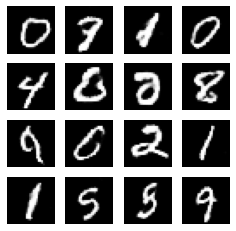

Time for epoch 152 is 24.496061325073242 sec
Generation loss: 0.7439669370651245 Discriminator loss: 1.304840087890625 
Time for epoch 153 is 24.550009727478027 sec
Generation loss: 0.8081341981887817 Discriminator loss: 1.2167924642562866 
Time for epoch 154 is 24.497434616088867 sec
Generation loss: 0.7575810551643372 Discriminator loss: 1.289161205291748 
Time for epoch 155 is 24.539353847503662 sec
Generation loss: 0.8438602089881897 Discriminator loss: 1.2899065017700195 
Time for epoch 156 is 24.567981243133545 sec
Generation loss: 0.8591282963752747 Discriminator loss: 1.1968958377838135 
Time for epoch 157 is 24.448797702789307 sec
Generation loss: 0.8476308584213257 Discriminator loss: 1.2093795537948608 
Time for epoch 158 is 24.541842222213745 sec
Generation loss: 0.7501559257507324 Discriminator loss: 1.3892323970794678 
Time for epoch 159 is 24.46267056465149 sec
Generation loss: 0.8057841062545776 Discriminator loss: 1.320380449295044 
Time for epoch 160 is 24.48785233497

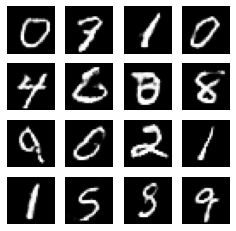

Time for epoch 202 is 24.512405157089233 sec
Generation loss: 0.802540123462677 Discriminator loss: 1.3153631687164307 
Time for epoch 203 is 24.490154504776 sec
Generation loss: 0.7805524468421936 Discriminator loss: 1.3142651319503784 
Time for epoch 204 is 24.533459901809692 sec
Generation loss: 0.7791545987129211 Discriminator loss: 1.3198546171188354 
Time for epoch 205 is 24.50806212425232 sec
Generation loss: 0.7696168422698975 Discriminator loss: 1.3223118782043457 
Time for epoch 206 is 24.507156133651733 sec
Generation loss: 0.791472852230072 Discriminator loss: 1.30120050907135 
Time for epoch 207 is 24.428053617477417 sec
Generation loss: 0.7492176294326782 Discriminator loss: 1.394336462020874 
Time for epoch 208 is 24.48801040649414 sec
Generation loss: 0.7904000282287598 Discriminator loss: 1.4169443845748901 
Time for epoch 209 is 24.47591996192932 sec
Generation loss: 0.7985962629318237 Discriminator loss: 1.3406105041503906 
Time for epoch 210 is 24.51773715019226 sec

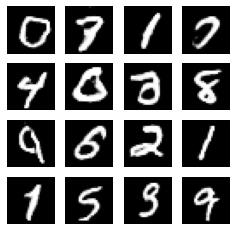

Time for epoch 252 is 24.46016216278076 sec
Generation loss: 0.8115921020507812 Discriminator loss: 1.3527393341064453 
Time for epoch 253 is 24.43576407432556 sec
Generation loss: 0.7850292325019836 Discriminator loss: 1.362483263015747 
Time for epoch 254 is 24.4618923664093 sec
Generation loss: 0.8040763139724731 Discriminator loss: 1.332005262374878 
Time for epoch 255 is 41.05716276168823 sec
Generation loss: 0.7590336799621582 Discriminator loss: 1.3223884105682373 
Time for epoch 256 is 24.563459873199463 sec
Generation loss: 0.7952825427055359 Discriminator loss: 1.309762716293335 
Time for epoch 257 is 24.424793481826782 sec
Generation loss: 0.772674560546875 Discriminator loss: 1.2845969200134277 
Time for epoch 258 is 24.511099815368652 sec
Generation loss: 0.7385253310203552 Discriminator loss: 1.3553811311721802 
Time for epoch 259 is 24.54507279396057 sec
Generation loss: 0.7645640969276428 Discriminator loss: 1.3315093517303467 
Time for epoch 260 is 24.585317611694336 s

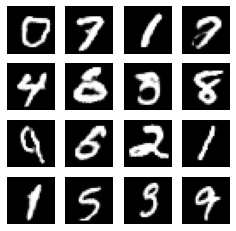

Time for epoch 302 is 24.513395309448242 sec
Generation loss: 0.7263918519020081 Discriminator loss: 1.3236773014068604 
Time for epoch 303 is 24.51258397102356 sec
Generation loss: 0.7892774343490601 Discriminator loss: 1.284407615661621 
Time for epoch 304 is 24.54680848121643 sec
Generation loss: 0.8021569848060608 Discriminator loss: 1.322896957397461 
Time for epoch 305 is 24.487064361572266 sec
Generation loss: 0.8137226104736328 Discriminator loss: 1.2913296222686768 
Time for epoch 306 is 24.58954167366028 sec
Generation loss: 0.766356348991394 Discriminator loss: 1.3354449272155762 
Time for epoch 307 is 24.549226760864258 sec
Generation loss: 0.7207299470901489 Discriminator loss: 1.3581972122192383 
Time for epoch 308 is 24.540919065475464 sec
Generation loss: 0.7826105356216431 Discriminator loss: 1.3327255249023438 
Time for epoch 309 is 24.52858066558838 sec
Generation loss: 0.751992404460907 Discriminator loss: 1.3245291709899902 
Time for epoch 310 is 24.529850721359253

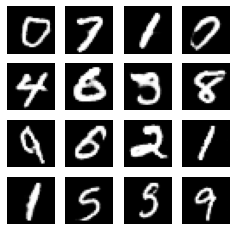

Time for epoch 352 is 24.560709476470947 sec
Generation loss: 0.7552134394645691 Discriminator loss: 1.3530843257904053 
Time for epoch 353 is 24.516741275787354 sec
Generation loss: 0.7627155780792236 Discriminator loss: 1.308812141418457 
Time for epoch 354 is 24.57493567466736 sec
Generation loss: 0.7560704350471497 Discriminator loss: 1.3611843585968018 
Time for epoch 355 is 24.51163959503174 sec
Generation loss: 0.7664605379104614 Discriminator loss: 1.3177344799041748 
Time for epoch 356 is 24.529021501541138 sec
Generation loss: 0.7505585551261902 Discriminator loss: 1.3493033647537231 
Time for epoch 357 is 24.503026485443115 sec
Generation loss: 0.7887512445449829 Discriminator loss: 1.3528770208358765 
Time for epoch 358 is 24.528618812561035 sec
Generation loss: 0.7352207899093628 Discriminator loss: 1.351332426071167 
Time for epoch 359 is 24.506425380706787 sec
Generation loss: 0.7384783625602722 Discriminator loss: 1.3740441799163818 
Time for epoch 360 is 24.49092650413

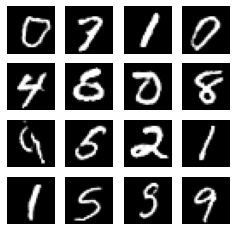

Time for epoch 402 is 24.940722227096558 sec
Generation loss: 0.706706166267395 Discriminator loss: 1.3289515972137451 
Time for epoch 403 is 24.917966842651367 sec
Generation loss: 0.7212492823600769 Discriminator loss: 1.3507080078125 
Time for epoch 404 is 24.96481227874756 sec
Generation loss: 0.791990339756012 Discriminator loss: 1.3135771751403809 
Time for epoch 405 is 24.90977144241333 sec
Generation loss: 0.7847706079483032 Discriminator loss: 1.3312385082244873 
Time for epoch 406 is 24.946433305740356 sec
Generation loss: 0.7637070417404175 Discriminator loss: 1.3358089923858643 
Time for epoch 407 is 24.89688205718994 sec
Generation loss: 0.7494559288024902 Discriminator loss: 1.3103641271591187 
Time for epoch 408 is 24.949168920516968 sec
Generation loss: 0.7686930894851685 Discriminator loss: 1.3720426559448242 
Time for epoch 409 is 24.91986584663391 sec
Generation loss: 0.7453905940055847 Discriminator loss: 1.3253779411315918 
Time for epoch 410 is 24.936896562576294 

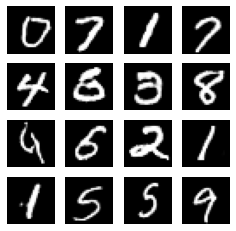

Time for epoch 452 is 24.947983264923096 sec
Generation loss: 0.7768058776855469 Discriminator loss: 1.3569369316101074 
Time for epoch 453 is 24.859325885772705 sec
Generation loss: 0.759906530380249 Discriminator loss: 1.3336005210876465 
Time for epoch 454 is 24.992116928100586 sec
Generation loss: 0.7593214511871338 Discriminator loss: 1.3203644752502441 
Time for epoch 455 is 24.847782611846924 sec
Generation loss: 0.7881014347076416 Discriminator loss: 1.3442678451538086 
Time for epoch 456 is 24.90203619003296 sec
Generation loss: 0.7929800748825073 Discriminator loss: 1.3004456758499146 
Time for epoch 457 is 24.880066633224487 sec
Generation loss: 0.692004382610321 Discriminator loss: 1.3563193082809448 
Time for epoch 458 is 24.942036867141724 sec
Generation loss: 0.7612990140914917 Discriminator loss: 1.3366985321044922 
Time for epoch 459 is 24.908786296844482 sec
Generation loss: 0.7879543304443359 Discriminator loss: 1.3542158603668213 
Time for epoch 460 is 24.9096930027

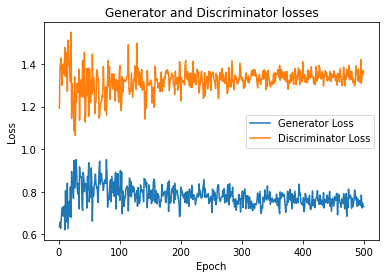

In [7]:
gan = DCGAN(data)
gan.make_generator_model()
gan.make_discriminator_model()
gan.dir()
gan.train_dcgan(epochs=500, save_interval=50)
gan.plot_losses()
gan.gif()

## In this part a test is provided.

In [43]:
def test_network_empty(network):
    error = 'When you create a network instance all networks should be None and addable by hand later.'
    assert network.generator is None, error
    assert network.discriminator is None, error

def test_functional(network):
    assert (isinstance(network.generator, Functional) ), """
    After building the generator must be a keras Functional."""
    assert (isinstance(network.discriminator, Functional)), """
    After building the discriminator must be a keras Functional."""
    
def test_shape(network):
    assert network.generator.output_shape == (None, 28, 28, 1), """
    After building the generator it must have a shape (None, 28, 28, 1)."""
    assert network.discriminator.output_shape == (None, 1) , """
        After building the encoder it must have shape (None, 1), but is
        """ + str(network.discriminator.output_shape)

In [46]:
test_data = mnist.MNISTData(data_fraction=1/100)
test_gan = DCGAN(test_data)

test_network_empty(test_gan)

test_gan.make_generator_model()
test_gan.make_discriminator_model()

test_functional(test_gan)
test_shape(test_gan)